@author: Adrien Loizeau

---
Please find in the notebook below the code for the
- [Sarsa Agent](#sarsa-agent)
- [Q-learning Agent](#q-learning-agent)
- [Training and testing loops](#train-and-test-loops)
- [Looking for best parameters](#looking-for-best-parameters)
- [Compare best policy](#pllotting-the-policy)



In [1]:
import os
import gymnasium as gym
import numpy as np
import time
import text_flappy_bird_gym
from tqdm import tqdm


Modules:
- $A$: [0,1] - Discret
- $S$: 308 - 14x22 - Discret
- $T$: 
- $R$: 1 - Discret, cumulative 

# Sarsa Agent

In [2]:
class ExpectedSarsaAgent:
    def __init__(self, num_states, num_actions, epsilon, step_size, discount):
        """Setup for the agent called when the experiment first starts.
        Args:
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        
        """
        self.num_states = num_states
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.step_size = step_size
        self.discount = discount
        self.q = np.zeros((self.num_states, self.num_actions))
        self.rand_generator = np.random.RandomState()

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        # Choose an action using epsilon greedy
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_test(self, state):
        current_q = self.q[state, :]
        action = self.argmax(current_q)
        return action

    def agent_step(self, reward, state, test = False):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        current_q = self.q[state,:]
        if test == False:
            if self.rand_generator.rand() < self.epsilon:
                action = self.rand_generator.randint(self.num_actions)
            else:
                action = self.argmax(current_q)
        else:
            action = self.argmax(current_q)

        probabilities = np.ones(self.num_actions) * self.epsilon / self.num_actions
        greedy_action = self.argmax(current_q)
        probabilities[greedy_action] += 1 - self.epsilon
        expected_value = np.dot(current_q, probabilities)
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount * expected_value - self.q[self.prev_state, self.prev_action])

        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward - self.q[self.prev_state, self.prev_action])

    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)


# Q learning agent

In [3]:
class QLearningAgent:
    def __init__(self, num_states, num_actions, epsilon, step_size, discount):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }

        """
        self.num_states = num_states
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.step_size = step_size
        self.discount = discount
        self.q = np.zeros((self.num_states, self.num_actions))
        self.rand_generator = np.random.RandomState()

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, state, test= False):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[state, :]

        if test == False:
            if self.rand_generator.rand() < self.epsilon:
                action = self.rand_generator.randint(self.num_actions)
            else:
                action = self.argmax(current_q)
        else:
            action = self.argmax(current_q)
        # Perform an update
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount * np.max(current_q) - self.q[self.prev_state, self.prev_action])

        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_test(self, state):
        current_q = self.q[state, :]
        action = self.argmax(current_q)
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward - self.q[self.prev_state, self.prev_action])
        
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

# Train and test loops

In [4]:
# initiate environment
def train(env, agent, num_episodes):

    # Train the agent
    end_total_reward = 0
    for i in range(num_episodes):
        # Start a new episode
        obs = env.reset()[0]
        action = agent.agent_start(state=obs[0]*22+obs[1]+11)
        done = False
        total_reward = 0

        # Run the episode
        while not done:
            obs, reward, done, _, _ = env.step(action)
            state = obs[0]*22+obs[1]+11
            action = agent.agent_step(reward=reward, state=state)
            total_reward += reward

        # Update the agent at the end of the episode
        agent.agent_end(reward=total_reward)
        
        # keep the reward   
        end_total_reward += total_reward
    return agent

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
num_states = (env.observation_space[0].n * env.observation_space[1].n)
qlearning_agent = QLearningAgent(num_states=num_states, num_actions=2, epsilon=0.5, step_size=0.5, discount=1.0)
qlearning_agent_trained = train(env, qlearning_agent, num_episodes=100)



In [5]:
# Test the agent
def test(agent, env):
    obs = env.reset()[0]
    action = agent.agent_test(state=obs[0]*22+obs[1]+11)
    done = False
    total_reward = 0

    while True:
        # Select next action
        obs, reward, done, _, info = env.step(action)
        state = obs[0]*22+obs[1]+11
        action = agent.agent_step(reward=reward, state=state, test= True)
        total_reward += reward
        # Render the game
        os.system("clear")
        #sys.stdout.write(env.render())

        # If player is dead break
        if done or info["score"] > 200:
            break
    env.close()
    return info["score"]
print("Score is ",test(qlearning_agent_trained, env))

Score is  0


In [6]:
# Training the model
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
num_episodes =100

# initiate environment
num_states = env.observation_space[0].n * (env.observation_space[1].n+11)
num_actions = env.action_space.n
sarsa_agent = ExpectedSarsaAgent(num_states=num_states, num_actions=num_actions, epsilon=0.5, step_size=0.1, discount=1.0)
sarsa_agent_trained = train(env, sarsa_agent, num_episodes)
print("Score is:",test(sarsa_agent_trained, env))

Score is: 0


# Looking for best parameters

In [7]:
import pandas as pd

run = 3
epsilon = [ 0.3, 0.4, 0.5, 0.6, 0.7]
step_sizes = [0.001, 0.01, 0.1, 0.2, 0.3]
num_episodes = 10000
results_df = pd.DataFrame(columns=["epsilon", "step_size", "score"])

for eps in tqdm(epsilon):
    for step_size in step_sizes:
        sum_score = 0
        for i in range(run):
            num_states = env.observation_space[0].n * (env.observation_space[1].n+11)
            num_actions = env.action_space.n
            agent = ExpectedSarsaAgent(num_states=num_states, num_actions=num_actions, epsilon=eps, step_size=step_size, discount=1.0)
            agent_trained = train(env, agent, num_episodes)
            score = test(agent_trained, env)
            sum_score += score

        mean_score = sum_score/run
        print("saved")
        results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
    results_df.to_csv("/Users/adrienloizeau/cs/rl-indiv-assignment/results/expected_sarsa.csv", index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
 20%|██        | 1/5 [04:37<18:29, 277.48s/it]

saved
saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
 40%|████      | 2/5 [08:31<12:36, 252.15s/it]

saved
saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
 60%|██████    | 3/5 [12:32<08:14, 247.09s/it]

saved
saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
 80%|████████  | 4/5 [15:46<03:45, 225.98s/it]

saved
saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/2544335263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
100%|██████████| 5/5 [19:33<00:00, 234.75s/it]

saved


In [10]:

run = 3
epsilon = [ 0.3, 0.4, 0.5, 0.6, 0.7]
step_sizes = [0.001, 0.01, 0.1, 0.2, 0.3]
num_episodes = 10000
results_df = pd.DataFrame(columns=["epsilon", "step_size", "score"])

for eps in tqdm(epsilon):
    for step_size in step_sizes:
        sum_score = 0
        for i in range(run):
            num_states = env.observation_space[0].n * (env.observation_space[1].n+11)
            num_actions = env.action_space.n
            agent = QLearningAgent(num_states=num_states, num_actions=num_actions, epsilon=eps, step_size=step_size, discount=1.0)
            agent_trained = train(env, agent, num_episodes)
            score = test(agent_trained, env)
            sum_score += score

        mean_score = sum_score/run
        print("saved")
        results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
    results_df.to_csv("/Users/adrienloizeau/cs/rl-indiv-assignment/results/qlearning.csv", index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
 20%|██        | 1/5 [03:49<15:19, 229.77s/it]

saved
saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
 40%|████      | 2/5 [07:10<10:38, 212.80s/it]

saved
saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
 60%|██████    | 3/5 [09:39<06:07, 183.77s/it]

saved
saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
 80%|████████  | 4/5 [13:08<03:13, 193.65s/it]

saved
saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/861774824.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"epsilon": eps, "step_size": step_size, "score": mean_score}, ignore_index=True)
100%|██████████| 5/5 [16:05<00:00, 193.13s/it]

saved


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_38520/485644855.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  results_pivot = results_df.pivot("epsilon", "step_size", "score")


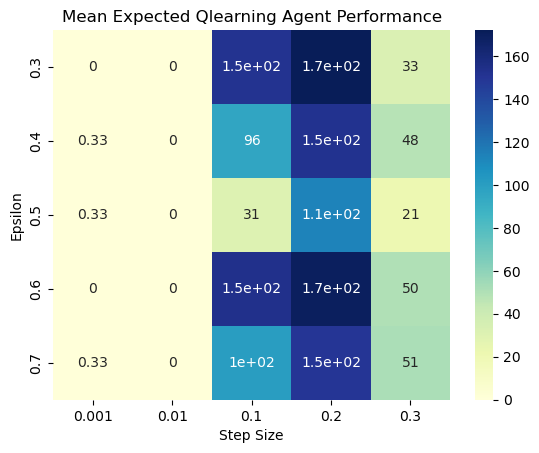

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grid_search(results_df):
    # Pivot the DataFrame to prepare it for plotting
    results_pivot = results_df.pivot("epsilon", "step_size", "score")

    # Create the heatmap using seaborn
    sns.heatmap(results_pivot, annot=True, cmap="YlGnBu")

    # Set the labels and title
    plt.xlabel("Step Size")
    plt.ylabel("Epsilon")
    plt.title("Mean Expected Qlearning Agent Performance")

    # Show the plot
    plt.show()
plot_grid_search(results_df)


# Plotting the policy

In [39]:
# Best q learning agent
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
num_states = (env.observation_space[0].n * env.observation_space[1].n)
qlearning_agent = QLearningAgent(num_states=num_states, num_actions=2, epsilon=0.3, step_size=0.2, discount=1.0)
qlearning_agent_trained = train(env, qlearning_agent, num_episodes=10000)


# Best expected sarsa agent
sarsa_agent = ExpectedSarsaAgent(num_states=num_states, num_actions=2, epsilon=0.7, step_size=0.1, discount=1.0)
sarsa_agent_trained = train(env, sarsa_agent, num_episodes=10000)

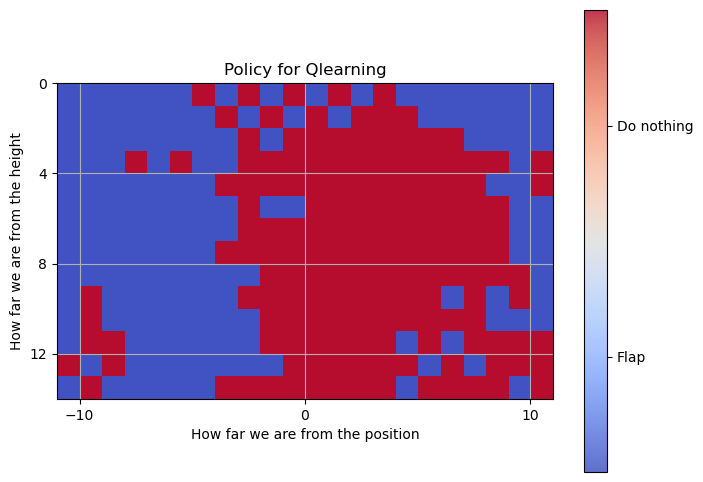

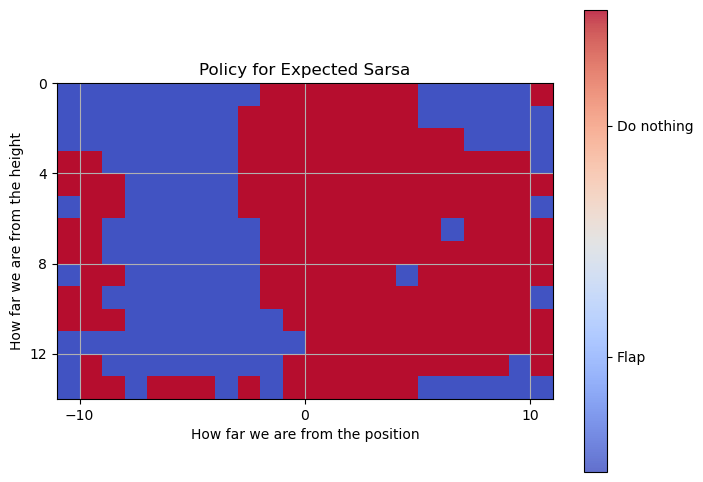

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Define the action labels
actions = ["Flap", "Do nothing"]
agents_name = ["Qlearning", "Expected Sarsa"]
# Define the state space
state_space = np.array([(i, j) for i in range(14) for j in range(-11, 11)])

for agent_id, agent in enumerate([qlearning_agent_trained, sarsa_agent_trained]):
    # Extract the policy for each state
    policy = np.argmax(agent.q, axis=1)

    # Create a 2D array that contains the recommended action for each combination of x and y positions
    heatmap_data = np.zeros((14, 22))
    for i in range(14):
        for j in range(-11, 11):
            state_idx = np.where((state_space[:,0]==i) & (state_space[:,1]==j))[0][0]
            heatmap_data[i, j+11] = policy[state_idx]

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.set_title("Policy for " + agents_name[agent_id])
    ax.set_xlabel("How far we are from the position")
    ax.set_ylabel("How far we are from the height")
    ax.set_xticks([-10, 0, 10])
    ax.set_yticks([0, 4, 8, 12])
    ax.set_xlim([-11, 11])
    ax.set_ylim([14, 0])
    ax.grid(True)

    # Display the heatmap
    ax.imshow(heatmap_data, cmap="coolwarm", extent=[-11, 11, 0, 14], alpha=0.8, vmin=0, vmax=1)
    cbar = plt.colorbar(ax.imshow(heatmap_data, cmap="coolwarm", extent=[-11, 11, 0, 14], alpha=0.8, vmin=0, vmax=1))
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(actions)

    plt.show()


# Compare both agents

100%|██████████| 100/100 [03:49<00:00,  2.29s/it]


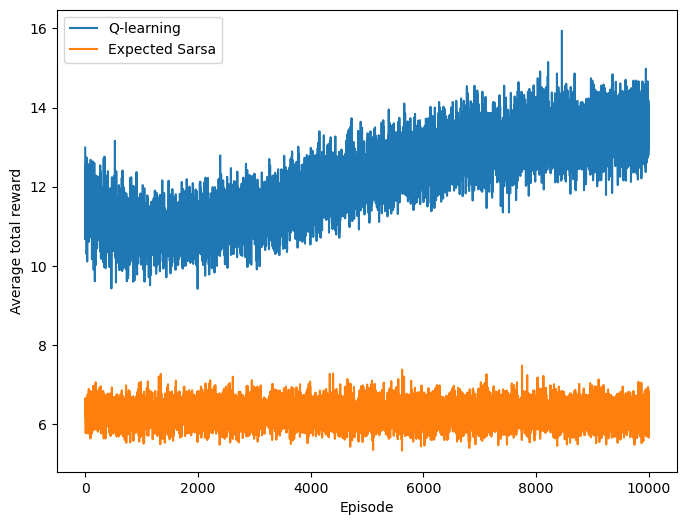

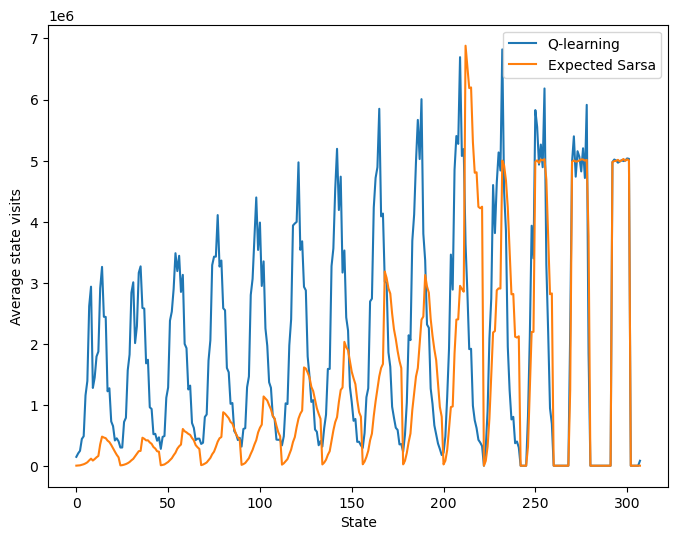

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt


# Define the environment parameters
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
num_states = (env.observation_space[0].n * env.observation_space[1].n)
num_actions = 2

# Define the agent parameters
agent_info = {"epsilon": 0.5 , "step_size": 0.05 , "discount": 0.9}

# Define the number of runs and episodes
num_runs = 100
num_episodes = 10000

# Define the agents to be compared
agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}

# Define the dictionaries to store the results
all_reward_sums = {}
all_state_visits = {}

# Loop through each algorithm and run it for num_runs times
for algorithm in agents.keys():
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        # Set a new seed for each run
        np.random.seed(run)

        # Create a new instance of the agent and environment for each run
        agent = agents[algorithm](num_states=num_states, num_actions=num_actions, **agent_info)
        env.reset()
        reward_sums = []
        state_visits = np.zeros(num_states)

        # Loop through each episode
        for episode in range(num_episodes):
            # Start a new episode
            obs = env.reset()[0]
            state = obs[0]*22+obs[1]+11
            action = agent.agent_start(state=state)
            done = False
            total_reward = 0

            # Run the episode
            while not done:
                obs, reward, done, _, _ = env.step(action)
                next_state = obs[0]*22+obs[1]+11
                next_action = agent.agent_step(reward=reward, state=next_state)
                total_reward += reward
                state = next_state
                action = next_action

            # End the episode and store the results
            agent.agent_end(reward=total_reward)
            reward_sums.append(total_reward)
            state_visits += agent.state_visits

        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)


# Plot the average total reward
plt.figure(figsize=(8, 6))
for algorithm in agents.keys():
    reward_sums = np.mean(all_reward_sums[algorithm], axis=0)
    plt.plot(reward_sums, label=algorithm)
plt.xlabel("Episode")
plt.ylabel("Average total reward")
plt.legend()
plt.show()

# Plot the average state visits
plt.figure(figsize=(8, 6))
for algorithm in agents.keys():
    state_visits = np.mean(all_state_visits[algorithm], axis=0)
    plt.plot(state_visits, label=algorithm)
plt.xlabel("State")
plt.ylabel("Average state visits")
plt.legend()
plt.show()



---
Thank you for reading ! 